# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *

In [3]:
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

# Load files

In [4]:
date_min_pres = '1980-01-01'
date_max_pres = '2022-12-31'

date_min_fut = '2048-01-01'
date_max_fut = '2080-12-31'

In [5]:
# lon_min = -13.5
# lon_max = 6.5
# lat_min = 32
# lat_max = 49
lon_min=-10
lon_max=4
lat_min=35.5
lat_max=44

## Format functions

In [6]:
def format_LMDZ_MO(filename, name, color=None, date_min=None, date_max=None, linestyle=None):
    """
    Format the LMDZ-MO output for plotting.
    """
    ds = xr.open_mfdataset(filename)
    ds.attrs['name'] = name
    ds.attrs['plot_color'] = color if color else 'blue'

    if linestyle is not None:
        ds.attrs["linestyle"] = linestyle
        
    rename_dict = {'time_counter':'time'}
    ds = ds.rename(rename_dict)

    ds = ds.coarsen(lat=2, lon=3, boundary='trim').mean()
    
    #restrict
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    else:
        print('No domain restriction applied, missing lon_min, lon_max, lat_min, lat_max')
    if date_min is not None and date_max is not None:
        ds = ds.sel(time=slice(date_min, date_max))
    else:
        print('No date restriction applied, missing date_min, date_max')

    #edit and convert units
    ds['evap'] = ds['evap'] *3600 * 24
    ds['evap'].attrs['units'] = 'mm d⁻¹'
    ds['evap'].attrs['name'] = 'ET'

    ds['precip'] = ds['precip'] *3600 * 24
    ds['precip'].attrs['units'] = 'mm d⁻¹'
    ds['precip'].attrs['name'] = 'Precipitation'

    ds['t2m'] = ds['t2m'] - 273.15
    ds['t2m'].attrs['units'] = '°C'
    ds['t2m'].attrs['name'] = '2-m temperature'

    ds['fluxsens']= -ds['sens']
    ds['fluxsens'].attrs['units'] = 'W m⁻²'
    ds['fluxsens'].attrs['name'] = 'Sensible heat flux'

    ds['fluxlat'] = - ds['flat']
    ds['fluxlat'].attrs['units'] = 'W m⁻²'
    ds['fluxlat'].attrs['name'] = 'Latent heat flux'

    # ds['netrad'] = ds['LWdnSFC'] - ds['LWupSFC'] + ds['SWdnSFC'] - ds['SWupSFC']
    # ds['netrad'].attrs['name'] = 'Surface net radiation'
    # ds['netrad'].attrs['units'] = 'W m⁻²'

    ds['SWnetSFC'] = ds['SWdnSFC'] - ds['SWupSFC']
    ds['SWnetSFC'].attrs['name'] = 'Surface net SW'
    ds['SWnetSFC'].attrs['units'] = 'W m⁻²'

    # ds['LWnetSFC'] = ds['LWdnSFC'] - ds['LWupSFC']
    # ds['LWnetSFC'].attrs['name'] = 'Surface net LW'
    # ds['LWnetSFC'].attrs['units'] = 'W m⁻²'

    ds['P - E'] = ds['precip'] - ds['evap']
    ds['P - E'].attrs['units'] = 'mm d⁻¹'

    #add names and units
    ds['SWdnSFC'].attrs['name'] = 'Surface SW down'
    ds['SWdnSFC'].attrs['units'] = 'W m⁻²'
    ds['LWdnSFC'].attrs['name'] = 'Surface LW down'
    ds['LWdnSFC'].attrs['units'] = 'W m⁻²'

    ds['cldt'] = ds['cldt'] * 100  # Convert to percentage
    ds['cldt'].attrs['name'] = 'Total cloud cover'
    ds['cldt'].attrs['units'] = '%'

    # ds['cldl'] = ds['cldl'] * 100  # Convert to percentage
    # ds['cldl'].attrs['name'] = 'Low cloud cover'
    # ds['cldl'].attrs['units'] = '%'

    ds['cldm'] = ds['cldm'] * 100  # Convert to percentage
    ds['cldm'].attrs['name'] = 'Medium cloud cover'
    ds['cldm'].attrs['units'] = '%'

    ds['cldh'] = ds['cldh'] * 100  # Convert to percentage
    ds['cldh'].attrs['name'] = 'High cloud cover'
    ds['cldh'].attrs['units'] = '%'

    ds['q2m'].attrs['name'] = '2-m specific humidity'
    ds['q2m'].attrs['units'] = 'kg kg⁻¹'
    ds['rh2m'].attrs['name'] = '2-m relative humidity'
    ds['rh2m'].attrs['units'] = '%'
    ds['s_pblh'].attrs['name'] = 'Boundary layer height'
    ds['s_pblh'].attrs['units'] = 'm'
    ds['s_lcl'].attrs['name'] = 'Lifting condensation level'
    ds['s_lcl'].attrs['units'] = 'm'
    
    ds['psol'] = ds['psol'] / 100  # Convert to hPa
    ds['psol'].attrs['name'] = 'Surface pressure'
    ds['psol'].attrs['units'] = 'hPa'

    ds['evap_frac'] = ds['fluxlat'] / (ds['fluxlat'] + ds['fluxsens']) 
    ds['evap_frac'].attrs['name'] = 'Evaporation fraction'
    ds['evap_frac'].attrs['units'] = '-'

    #remove history, description, title, Conventions, timeStamp, uuid, NCO :
    for attr in ['history', 'description', 'title', 'Conventions', 'timeStamp', 'uuid', 'NCO']:
        if attr in ds.attrs:
            del ds.attrs[attr]

    return ds

In [7]:
def format_ORC_MO(filename, name, color=None, date_min=None, date_max=None, linestyle=None):
    """
    Format the ORC output for plotting.
    """
    ds = xr.open_mfdataset(filename)
    ds.attrs['name'] = name

    if color is not None:
        ds.attrs['plot_color'] = color
    
    if linestyle is not None:
        ds.attrs["linestyle"] = linestyle

    rename_dict = {'time_counter':'time'}
    ds = ds.rename(rename_dict)


    ds = ds.coarsen(lat=2, lon=3, boundary='trim').mean()

    #restrict
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    else:
        print('No domain restriction applied, missing lon_min, lon_max, lat_min, lat_max')
    if date_min is not None and date_max is not None:
        ds = ds.sel(time=slice(date_min, date_max))
    else:
        print('No date restriction applied, missing date_min, date_max')


    #edit units and names
    # if 'streamr' in ds:
    #     ds['streamr'].attrs['units'] = 'kg/m²'
    #     ds['streamr'].attrs['long_name'] = 'River reservoir volume'
    # if 'slowr' in ds:
    #     ds['slowr'].attrs['units'] = 'kg/m²'
    #     ds['slowr'].attrs['long_name'] = 'GW reservoir volume'
    # if 'fastr' in ds:
    #     ds['fastr'].attrs['units'] = 'kg/m²'
    #     ds['fastr'].attrs['long_name'] = 'Overland reservoir volume'
    if 'evapot_corr' in ds:
        ds['evapot_corr'] = ds['evapot_corr'] * 3600 * 24
        ds['evapot_corr'].attrs['units'] = 'mm d⁻¹'
        ds['evapot_corr'].attrs['long_name'] = 'PET'
    if 'irrigmap_dyn' in ds and 'Areas' in ds:
        ds['irrig_frac'] = ds['irrigmap_dyn'] / ds['Areas'] *100
        ds['irrig_frac'].attrs['units'] = '%'
        ds['irrig_frac'].attrs['long_name'] = 'Grid cell irrigation fraction'


    # ds['evap_frac'] = ds['fluxlat'] / (ds['fluxlat'] + ds['fluxsens']) 
    # ds['evap_frac'].attrs['name'] = 'Evaporation fraction'
    # ds['evap_frac'].attrs['units'] = '-'
    
    if 'coastalflow' in ds and 'riverflow' in ds:
        ds['coast_and_river'] = ds['coastalflow'] + ds['riverflow']
        ds['coast_and_river'].attrs['units'] = 'm³/s'
        ds['coast_and_river'].attrs['long_name'] = 'Coastal and river flow'
        
    #remove history, description, title, Conventions, timeStamp, uuid, NCO :
    for attr in ['history', 'description', 'title', 'Conventions', 'timeStamp', 'uuid', 'NCO']:
        if attr in ds.attrs:
            del ds.attrs[attr]
        
    return ds

## LMDZ

In [8]:
present_noirr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_FC/pres_noirr/'
present_irr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_FC/pres_irr/'
future_noirr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_FC/fut_noirr'
future_irr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_FC/fut_irr'

In [9]:
filename = '{}/ATM/light_2D/*.nc'.format(present_noirr_dir)
color= 'red'
linestyle='-'
lmdz_pres_noirr = format_LMDZ_MO(filename, 'present, no_irr', color=color, date_min=date_min_pres, date_max=date_max_pres, linestyle=linestyle)
lmdz_pres_noirr

<xarray.Dataset> Size: 93MB
Dimensions:               (time: 360, lat: 42, lon: 44, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 1985-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/37)
    LWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWupSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_max     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_min     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    cape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    wape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxlat               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    evap_frac             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        present, no_irr
    plot_color:  red
    linestyle:   -

In [10]:
filename = '{}/ATM/light_2D/*.nc'.format(present_irr_dir)
color= 'blue'
lmdz_pres_irr = format_LMDZ_MO(filename, 'present, irr', color=color, date_min=date_min_pres, date_max=date_max_pres, linestyle='-')
lmdz_pres_irr

<xarray.Dataset> Size: 93MB
Dimensions:               (time: 360, lat: 42, lon: 44, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 1985-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/37)
    LWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWupSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_max     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_min     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    cape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    wape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxlat               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    evap_frac             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        present, irr
    plot_color:  blue
    linestyle:   -

In [11]:
filename = '{}/ATM/light_2D/*.nc'.format(future_noirr_dir)
color = 'red'
lmdz_fut_noirr = format_LMDZ_MO(filename, 'future, no_irr', color=color, date_min=date_min_fut, date_max=date_max_fut, linestyle='--')
lmdz_fut_noirr

<xarray.Dataset> Size: 93MB
Dimensions:               (time: 360, lat: 42, lon: 44, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 2048-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/37)
    LWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWupSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_max     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_min     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    cape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    wape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxlat               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    evap_frac             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        future, no_irr
    plot_color:  red
    linestyle:   --

In [12]:
filename = '{}/ATM/light_2D/*.nc'.format(future_irr_dir)
color = 'blue'
lmdz_fut_irr = format_LMDZ_MO(filename, 'future, irr', color=color, date_min=date_min_fut, date_max=date_max_fut, linestyle='--')
lmdz_fut_irr

<xarray.Dataset> Size: 93MB
Dimensions:               (time: 360, lat: 42, lon: 44, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 2048-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/37)
    LWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWdnSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWupSFC               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_max     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ave_t2m_daily_min     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    cape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    wape                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    fluxlat               (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    evap_frac             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        future, irr
    plot_color:  blue
    linestyle:   --

## ORC

In [13]:
filename = '{}/SRF/*sechiba_history.nc'.format(present_noirr_dir)
color = 'red'
orc_pres_noirr = format_ORC_MO(filename, 'present, no_irr', color=color, date_min=date_min_pres, date_max=date_max_pres, linestyle='-')
orc_pres_noirr

<xarray.Dataset> Size: 812MB
Dimensions:               (time: 360, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 1985-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/78)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    Contfrac              (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    aei_sw                (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    RootDist              (time, solay, lat, lon) float32 29MB dask.array<chunksize=(12, 11, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
Attributes:
    name:        present, no_irr
    plot_color:  red
    linestyle:   -

In [14]:
filename = '{}/SRF/*sechiba_history.nc'.format(present_irr_dir)
color = 'blue'
orc_pres_irr = format_ORC_MO(filename, 'present, irr', color=color, date_min=date_min_pres, date_max=date_max_pres, linestyle='-')
orc_pres_irr

<xarray.Dataset> Size: 841MB
Dimensions:               (time: 360, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 1985-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/89)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    Contfrac              (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    Count_failure_stre    (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    irrig_frac            (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        present, irr
    plot_color:  blue
    linestyle:   -

In [15]:
filename = '{}/SRF/*sechiba_history.nc'.format(future_noirr_dir)
color = 'red'
linestyle='--'
orc_fut_noirr = format_ORC_MO(filename, 'future, no_irr', color=color, linestyle=linestyle, date_min=date_min_fut, date_max=date_max_fut)
orc_fut_noirr

<xarray.Dataset> Size: 812MB
Dimensions:               (time: 360, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 2048-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/78)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    Contfrac              (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    aei_sw                (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    RootDist              (time, solay, lat, lon) float32 29MB dask.array<chunksize=(12, 11, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
Attributes:
    name:        future, no_irr
    plot_color:  red
    linestyle:   --

In [16]:
filename = '{}/SRF/*sechiba_history.nc'.format(future_irr_dir)
color = 'blue'
orc_fut_irr = format_ORC_MO(filename, 'future, irr', color=color, date_min=date_min_fut, date_max=date_max_fut, linestyle='--')
orc_fut_irr

<xarray.Dataset> Size: 841MB
Dimensions:               (time: 360, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 3kB 2048-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/89)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    Contfrac              (time, lat, lon) float32 3MB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    Count_failure_stre    (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 8MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    irrig_frac            (time, lat, lon) float32 3MB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:        future, irr
    plot_color:  blue
    linestyle:   --

## Masks and interp

In [17]:
#define masks
con_mask_pres=lmdz_pres_noirr['pourc_ter']>95
ip_mask_pres=polygon_to_mask(lmdz_pres_noirr, iberian_peninsula)

con_mask_fut=lmdz_fut_irr['pourc_ter']>95
ip_mask_fut=polygon_to_mask(lmdz_fut_irr, iberian_peninsula)

#apply masks
ip_lmdz_pres_noirr = lmdz_pres_noirr.where(ip_mask_pres, drop=False).where(con_mask_pres)
ip_lmdz_pres_irr = lmdz_pres_irr.where(ip_mask_pres, drop=False).where(con_mask_pres)
ip_lmdz_fut_noirr = lmdz_fut_noirr.where(ip_mask_fut, drop=False).where(con_mask_fut)
ip_lmdz_fut_irr = lmdz_fut_irr.where(ip_mask_fut, drop=False).where(con_mask_fut)

ip_orc_pres_noirr = orc_pres_noirr.where(ip_mask_pres, drop=False).where(con_mask_pres)
ip_orc_pres_irr = orc_pres_irr.where(ip_mask_pres, drop=False).where(con_mask_pres)
ip_orc_fut_noirr = orc_fut_noirr.where(ip_mask_fut, drop=False).where(con_mask_fut)
ip_orc_fut_irr = orc_fut_irr.where(ip_mask_fut, drop=False).where(con_mask_fut)

In [18]:
#mean DS
ip_lmdz_pres_noirr_mean = mean_dataset(ip_lmdz_pres_noirr)
ip_lmdz_pres_irr_mean = mean_dataset(ip_lmdz_pres_irr)
ip_lmdz_fut_noirr_mean = mean_dataset(ip_lmdz_fut_noirr)
ip_lmdz_fut_irr_mean = mean_dataset(ip_lmdz_fut_irr)    

# Tests

In [19]:
stop

NameError: name 'stop' is not defined

## Maps

In [ ]:
#Display map of var for ds
var='irrigation'
ds=ip_orc_pres_irr
color_map=wet
min_value=0
max_value=0.6
# min_value, max_value = None, None

map_ave(ds, var, cmap=color_map, vmin=min_value, vmax=max_value, hex=False)

In [ ]:
#Diff map
var='evap'
# ds1=ip_lmdz_fut_noirr_mean
# ds2=ip_lmdz_pres_noirr_mean

ds1=ip_orc_fut_noirr
ds2=ip_orc_pres_noirr

max_value= 1
min_value=-1
# max_value, min_value = None, None

color_map=emb_neutral
# color_map=emb

# title='Evapotranspiration bias (mm d⁻¹, {} - {})'.format( ds1.attrs['name'], ds2.attrs['name'])
title=None

map_diff_ave(ds1, ds2, var, 
             vmin=min_value, vmax=max_value, 
             title=title, cmap=color_map,
            #  sig=True
             )

# diff=ds1[var]-ds2[var]
# title='{} bias, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])
# map_seasons(diff, cmap=color_map,  vmin=min_value, vmax=max_value, title=title, hex=False)

In [ ]:
#Relative diff map
var='cldm'
ds1=ip_lmdz_fut_noirr_mean
ds2=ip_lmdz_pres_noirr_mean

# ds1=ip_lmdz_fut_irr
# ds2=ip_lmdz_fut_noirr

max_value=25
min_value=-max_value
min_value, max_value = None, None

map_rel_diff_ave(ds1, ds2, var, vmin=min_value, vmax=max_value)

In [ ]:
#map for 4 seasons
var='precip'
ds1=lmdz_fut_noirr
ds2=lmdz_fut_irr
max_value=2
min_value=None
# min_value=-max_value

diff=ds1[var]-ds2[var]
title='{} bias, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])
plotvar=diff

# plotvar=ds1[var]
# title='P-E (mm d⁻¹, {})'.format(ds1.attrs['name'])

map_seasons(plotvar, cmap=emb, vmax=max_value, title=title, hex=False)

## Time series

In [ ]:
var='precip'


ds1 = ip_lmdz_pres_noirr
ds2 = ip_lmdz_pres_irr
ds3 = ip_lmdz_fut_noirr
ds4 = ip_lmdz_fut_irr

ds_list=[ds1, ds2, ds3, ds4]

year_min, year_max = 2048, 2062
year_min, year_max = 2010, 2022
year_min, year_max = 1980, 2080

time_series_ave(ds_list, var,
                title='{} {}'.format(var, ds1[var].attrs['units']),
                ds_colors=True,
                year_min=year_min, year_max=year_max)
seasonal_cycle_ave(ds_list, var, 
                   title='Seasonal cycle of {} ({})'.format(var, ds1[var].attrs['units']),
                   ds_colors=True,
                   year_min=year_min, year_max=year_max)

# Figures

## Domain

In [ ]:
import psyplot.project as psy
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [8, 6.]

LAM_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_FC/'
start_file='{}/ICO_TEST-amip-LAMCM7onlyirr.1n-85_19850131_restart.nc'.format(LAM_dir)
start=xr.open_dataset(start_file)
# start
start["Altitude"] = start["phis"]/9.81
start["Altitude"].attrs["units"] = "m"
start["Altitude"].attrs["long_name"] = "Altitude"
start["Altitude"].attrs["standard_name"] = "Altitude"

start_file2='{}/espagne_start_2010_modified.nc'.format(LAM_dir)
start.to_netcdf(start_file2)
start2=xr.open_dataset(start_file2)
# start2
# Custom colormap
terrain_colors = plt.cm.terrain(np.linspace(0, 1, 25))
filtered_colors = terrain_colors[5:]  
# Insert blue as the first color
filtered_colors = np.vstack([[0.07973856209150328, 0.44052287581699345, 0.8405228758169935, 1.0], filtered_colors]) 
custom_colormap = ListedColormap(filtered_colors)

file=start_file2
var='Altitude'
vmin=-0
vmax=2000
pas=(vmax-vmin) / 20

map=psy.plot.mapplot(
    file, 
    name=var,
    datagrid=dict(color='k', linewidth=0.2),
    cbar='r',
    tight=True,
    lsm='50m',
    cmap=custom_colormap,
    extend='both',
    projection='ortho',
    xgrid=True,ygrid=True,
    bounds=np.arange(vmin, vmax + pas, pas),
    # title=var,
    clabel="Altitude (m)"
)

## Present vs Future

### Annual diff maps

In [ ]:
savefig=True
vars=['precip', 'evap', 't2m', 'fluxsens', 'q2m', 's_pblh', 's_lcl', 'rh2m', 'psol']
# vars=['precip']
vmaxs=[1, 0.5, 4, 15, 1e-3, 50, 200, 7, 1.80]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb_neutral, emb, emb, emb_neutral, emb]

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

ds1_mean = ds1.mean(dim='time')
ds2_mean = ds2.mean(dim='time')

for var in vars:
    title='off'
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1_mean, ds2_mean, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                )

In [ ]:
savefig=True
vars=['SWdnSFC', 'LWdnSFC', 'cldt']#, 'cldm', 'cldh']
# vars=['precip']
vmaxs=[20, 20, 10, 10, 5, 1]
cmap=emb

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

ds1_mean = ds1.mean(dim='time')
ds2_mean = ds2.mean(dim='time')

for var in vars:
    title='off'
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1_mean, ds2_mean, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmap
                )

In [ ]:
vars=[ 'evap', 'rh2m', 't2m', 'precip']#,'fluxsens', 'q2m', 's_pblh', 's_lcl',  'LWdnSFC', 'SWdnSFC', 'cldt', 'cldm', 'cldh']

fig,axes= plt.subplots(2,2, figsize=(18,8), subplot_kw={'projection': ccrs.PlateCarree()})
axes=axes.flatten()

vmaxs=[0.5,7, 4, 1]
cmaps=[emb_neutral, emb_neutral, emb, emb_neutral]

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

ds1_mean = ds1#.mean(dim='time')
ds2_mean = ds2#.mean(dim='time')

for var in vars:
    title='{} diff. (future - present, no_irr)'.format(ds1[var].attrs['name'])
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1_mean, ds2_mean, var, 
                ax=axes[vars.index(var)],
                vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                sig=True
                )

### Summer diff maps

In [ ]:
savefig=True
vars=['precip', 'evap', 't2m', 'fluxsens', 'q2m', 's_pblh', 's_lcl', 'rh2m']
# vars=['precip']
vmaxs=[2, 1, 4, 30, 1e-3, 150, 450, 10]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb_neutral, emb, emb, emb_neutral]

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

months=[6,7,8]  # JJA
ds1 = ds1.sel(time=ds1['time.month'].isin(months))
ds2 = ds2.sel(time=ds2['time.month'].isin(months))
ds1_mean = ds1.mean(dim='time')
ds2_mean = ds2.mean(dim='time')

for var in vars:
    title='off'
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1_mean, ds2_mean, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                )
    if savefig:
        plt.savefig('figures/chap4/future/diffmap_JJA_{}_presfut.png'.format(var), bbox_inches='tight', dpi=300)

### Relative diff map (annual)

In [ ]:
savefig=True
vars=['precip', 'evap', 'fluxsens', 'SWdnSFC', 'LWdnSFC', 'q2m', 'rh2m', 'psol']
# vars=['precip']
vmaxs=[35, 35, 45, 10, 5, 10, 8, 0.2]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb, emb_neutral, emb_neutral, emb]

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

ds1_mean = ds1.mean(dim='time')
ds2_mean = ds2.mean(dim='time')

for var in vars:
    title='off'
    ylabel='{} rel. diff. (%)'.format(ds1[var].attrs['name'])
    map_rel_diff_ave(ds1_mean, ds2_mean, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                )
    if savefig:
        plt.savefig('figures/chap4/future/reldiffmap_{}_presfut.png'.format(var), bbox_inches='tight', dpi=300)

In [ ]:
savefig=True
vars=['SWdnSFC', 'LWdnSFC', 'netrad', 'cldt', 'cldl', 'cldm', 'cldh']
vmaxs=[10, 10, 10, 15, 25, 20, 10]
cmap=emb

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr

ds1_mean = ds1.mean(dim='time')
ds2_mean = ds2.mean(dim='time')

for var in vars:
    title='off'
    ylabel='{} rel. diff. (%)'.format(ds1[var].attrs['name'])
    map_rel_diff_ave(ds1_mean, ds2_mean, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmap,
                )
    if savefig:
        plt.savefig('figures/chap4/future/reldiffmap_{}_presfut.png'.format(var), bbox_inches='tight', dpi=300)

## Future only, irr vs noirr

### Irr maps and SC

In [ ]:
savefig=True
ds=ip_orc_fut_irr
var = 'irrig_frac'
map_ave(ds,var, cmap=reds,
        vmin=0, vmax=50,
        title='off', clabel='Grid cell irrigation fraction (%)')
if savefig:
    plt.savefig('figures/chap4/future/map_{}_fut.png'.format(var), bbox_inches='tight', dpi=300)

In [ ]:
savefig=False
ds=ip_orc_fut_irr
var = 'root_deficit'
map_ave(ds,var, cmap=reds,
        # vmin=0, vmax=50,
        title='off', 
        # clabel='Grid cell irrigation fraction (%)'
        )
if savefig:
    plt.savefig('figures/chap4/future/map_{}_fut.png'.format(var), bbox_inches='tight', dpi=300)

present, irr : 1.15 (mm/d)
future, irr : 1.41 (mm/d)


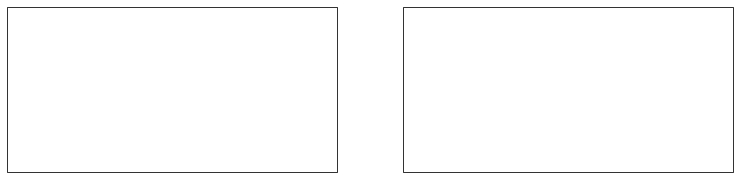

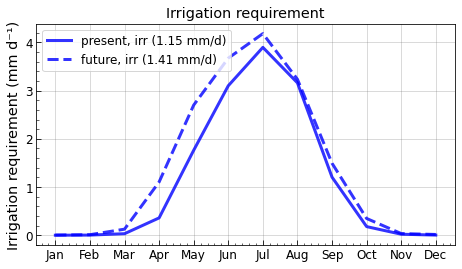

In [ ]:
ds1=ip_orc_pres_irr
ds2=ip_orc_fut_irr
var = 'netirrig'
fig, axes= plt.subplots(1,2, figsize=(13,3.5), subplot_kw={'projection': ccrs.PlateCarree()})

# map_ave(ds1,var, 
#         cmap=blues,
#         ax=axes[0],
#         vmin=0, vmax=10,
#         title='Irrigation requirement (present, irr)', 
#         clabel='Irrigation requirement (mm d⁻¹)')

# map_ave(ds2, var, cmap=blues,
#         vmin=0, vmax=10,
#         ax=axes[1],
#         title='Irrigation requirement (future, irr)', 
#           clabel='Irrigation requirement (mm d⁻¹)')

# time_series_ave([ds1, ds2], var, year_min=2048, year_max=2080)

seasonal_cycle_ave([ds1, ds2], var, year_min=1980, year_max=2080,
                   title='Irrigation requirement', 
                   ylabel='Irrigation requirement (mm d⁻¹)', ds_colors=True, ds_linestyle=True
                        )

present, irr : 0.09 (mm/d)
future, irr : 0.08 (mm/d)


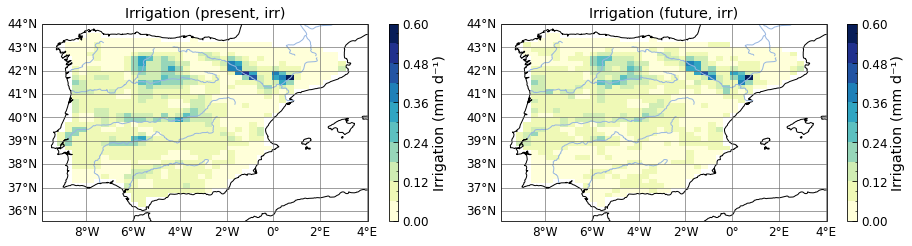

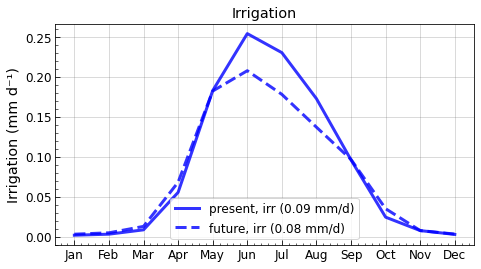

In [ ]:
ds1=ip_orc_pres_irr
ds2=ip_orc_fut_irr
var = 'irrigation'
fig, axes= plt.subplots(1,2, figsize=(13,3.5), subplot_kw={'projection': ccrs.PlateCarree()})

map_ave(ds1,var, 
        cmap=wet,
        ax=axes[0],
        vmin=0, vmax=0.6,
        title='Irrigation (present, irr)',
        clabel='Irrigation (mm d⁻¹)')

map_ave(ds2,var, cmap=wet,
        vmin=0, vmax=0.6,
        ax=axes[1],
        title='Irrigation (future, irr)', 
        clabel='Irrigation (mm d⁻¹)')

# time_series_ave([ds1, ds2], var, year_min=1980, year_max=2080)

seasonal_cycle_ave([ds1, ds2], var, year_min=1980, year_max=2080, 
                   title='Irrigation',
                   ylabel='Irrigation (mm d⁻¹)', ds_colors=True, ds_linestyle=True
                        )

In [20]:
ip_orc_pres_irr['irrigation'].mean().values

array(0.0865322, dtype=float32)

In [21]:
ip_orc_fut_irr['irrigation'].mean().values

array(0.07792456, dtype=float32)

In [22]:
ip_orc_pres_irr['netirrig'].mean().values

array(1.1450491, dtype=float32)

In [23]:
ip_orc_fut_irr['netirrig'].mean().values

array(1.4115461, dtype=float32)

In [25]:
(1.4115461 - 1.1450491)/1.1450491

0.23273849130137736

In [27]:
(0.07792456 - 0.0865322) / 0.0865322 *100

-9.947325966518822

### Annual diff maps

In [ ]:
savefig=True
vars=['precip', 'evap', 't2m', 'fluxsens', 'q2m', 's_pblh', 's_lcl', 'rh2m']
# vars=['precip']

vmaxs=[0.25, 0.75, 0.5, 15, 1e-3, 100, 200, 4]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb_neutral, emb, emb, emb_neutral]

ds1= ip_lmdz_fut_irr
ds2= ip_lmdz_fut_noirr

for var in vars:
    title='off'
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1, ds2, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                # sig=True,
                )
    if savefig:
        plt.savefig('figures/chap4/future/diffmap_{}_futirr.png'.format(var), bbox_inches='tight', dpi=300)

In [ ]:
savefig=False
vars=['rain', 'humtot', 'runoff', 'drainage', 'slowr', 'fastr', 'streamr']
# vars=['twbr']
# vars=['precip']
vmaxs=[100, 100, 100]

cmap = emb_neutral


for var in vars:
    # map_ave(ip_orc_pres_noirr, var)
    # map_ave(ip_orc_fut_noirr, var)
    # map_ave(ip_orc_fut_irr, var)

    if savefig:
        plt.savefig('figures/chap4/future/reldiffmap_{}_futirr.png'.format(var), bbox_inches='tight', dpi=300)

In [ ]:
savefig=False
vars=['rain', 'humtot', 'runoff', 'drainage', 'slowr', 'fastr', 'streamr']
# vars=['twbr']
# vars=['precip']
vmaxs=[100, 100, 100]

cmap = emb_neutral

for var in vars:
    map_diff_ave(ip_orc_fut_irr, ip_orc_fut_noirr, var,
                 cmap=cmap
            )
    map_rel_diff_ave(ip_orc_fut_irr, ip_orc_fut_noirr, var,
                 cmap=cmap,
                 vmin=-100,
                 vmax=100
            )

    if savefig:
        plt.savefig('figures/chap4/future/reldiffmap_{}_futirr.png'.format(var), bbox_inches='tight', dpi=300)

### Summer diff maps

In [ ]:
savefig=False
vars=['precip', 'evap', 't2m', 'fluxsens', 'q2m', 's_pblh', 's_lcl', 'rh2m']
# vars=['precip']

vmaxs=[0.5, 1.8, 1.25, 40, 1.8e-3, 250, 500, 10]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb_neutral, emb, emb, emb_neutral]

ds1= ip_lmdz_fut_irr
ds2= ip_lmdz_fut_noirr

months=[6,7,8]  # JJA
# months=[0,10,11]  # MAM
ds1 = ds1.sel(time=ds1['time.month'].isin(months))
ds2 = ds2.sel(time=ds2['time.month'].isin(months))

for var in vars:
    title='off'
    ylabel='{} diff. ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    map_diff_ave(ds1, ds2, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                # sig=True,
                )
    if savefig:
        plt.savefig('figures/chap4/future/diffmap_JJA_{}_futirr.png'.format(var), bbox_inches='tight', dpi=300)

### Annual rel diff maps

In [ ]:
savefig=True
vars=['precip', 'evap', 'fluxsens', 's_pblh', 's_lcl', 'q2m', 'rh2m', 'psol']
# vars=['precip']

vmaxs=[10, 75, 25, 10, 15, 10, 10, 0.02]
cmaps=[emb_neutral, emb_neutral, emb, emb, emb,emb_neutral, emb_neutral, emb]

ds1= ip_lmdz_fut_irr
ds2= ip_lmdz_fut_noirr

for var in vars:
    title='off'
    ylabel='{} rel. diff. (%)'.format(ds1[var].attrs['name'])
    map_rel_diff_ave(ds1, ds2, var, 
                 vmin=-vmaxs[vars.index(var)], vmax=vmaxs[vars.index(var)],
                title=title, 
                clabel=ylabel,
                cmap=cmaps[vars.index(var)],
                )
    if savefig:
        plt.savefig('figures/chap4/future/reldiffmap_{}_futirr.png'.format(var), bbox_inches='tight', dpi=300)

## Aridity index

### Maps

In [ ]:
def penman_monteith_pet(ds_lmdz,ds_orc) -> xr.DataArray:
    """
    Computes Potential Evapotranspiration (PET) using the Penman-Monteith equation,
    incorporating the bulk drag coefficient (cdrag) for aerodynamic resistance.
    All constants and intermediate calculations are performed inline.

    Args:
        ds: xarray.Dataset containing the necessary model variables.
            Requires: netrad (W/m^2), Qg (W/m^2), tair (K), qair (kg/kg),
                      Wind (m/s), psol (Pa), and cdrag (dimensionless, bulk drag coefficient).

    Returns:
        xr.DataArray: Potential Evapotranspiration in mm/day.
    """
    # --- 1. Physical Constants and Standard Values ---
    # Specific heat of air at constant pressure (J kg^-1 K^-1)
    CP_AIR = 1004.0
    # Ratio of molecular weight of water vapor/dry air (dimensionless)
    EPSILON = 0.622
    # Gas constant for dry air (J kg^-1 K^-1)
    R_D = 287.0
    # Density of water (kg m^-3)
    RHO_W = 1000.0

    # --- 2. Extract Variables (Ensure correct units) ---
    Rn = ds_orc['netrad']
    G = ds_orc['Qg']
    Ta = ds_orc['tair']   # Air Temperature (K)
    qa = ds_orc['qair']   # Specific Humidity (kg/kg)
    u = ds_orc['Wind']    # Wind Speed (m/s)
    P = ds_lmdz['psol'] * 100  # Surface Pressure (Pa)
    Cdrag = ds_orc['cdrag'] # Dynamic Bulk Drag Coefficient (dimensionless)

    # --- 3. Intermediate Calculations ---
    # Convert Air Temperature to Celsius
    tair_c = Ta - 273.15

    # 3.1 Latent Heat of Vaporization (Lv) in J kg^-1 (Temperature dependent)
    # Lv = 2.501 x 10^6 - 2361 * T_c
    Lv = (2.501e6 - 2361.0 * tair_c)

    # 3.2 Saturation Vapour Pressure (es) in Pa (Tetens formula)
    # es = 0.6108 * exp((17.27 * T_c) / (T_c + 237.3)) * 1000 (kPa to Pa)
    es = (0.6108 * np.exp((17.27 * tair_c) / (tair_c + 237.3))) * 1000.0

    # 3.3 Slope of the Saturation Vapour Pressure Curve (Delta) in Pa K^-1
    # Delta = (4098 * es) / (T_c + 237.3)^2
    Delta = (4098.0 * es) / ((tair_c + 237.3) ** 2)

    # 3.4 Psychrometric Constant (gamma) in Pa K^-1
    # gamma = (CP_AIR * P) / (EPSILON * L_v)
    gamma = (CP_AIR * P) / (EPSILON * Lv)

    # 3.5 Air Density (rho_a) in kg m^-3 (assuming dry air for simplicity)
    # rho_a = P / (R_D * T_a)
    rho_a = P / (R_D * Ta)

    # 3.6 Aerodynamic Resistance (ra) in s m^-1
    # ra = 1 / (Cdrag * u)
    # This uses the bulk transfer coefficient (Cdrag) and wind speed (u)
    ra = 1.0 / (Cdrag * u)

    # 3.7 Actual Vapour Pressure (ea) in Pa (Simplified from specific humidity)
    # ea ≈ P * qa / EPSILON
    ea = P * qa / EPSILON
    VPD = es - ea # Vapour Pressure Deficit (Pa)

    # --- 4. Penman-Monteith Equation for Latent Heat Flux (LE) ---

    # Numerator - Energy Term: Delta * (Rn - G)
    term_energy = Delta * (Rn - G)

    # Numerator - Aerodynamic Term: rho * cp * VPD / ra
    term_aero = rho_a * CP_AIR * VPD / ra

    # Denominator: Delta + gamma (1 + rc/ra)
    # For PET, surface resistance rc is set to zero (rc = 0), so Denom = Delta + gamma
    denominator = Delta + gamma

    # LE (W/m^2)
    LE = (term_energy + term_aero) / denominator
    LE.name = 'LE_PET'
    LE.attrs['units'] = 'W/m^2'

    # --- 5. Convert LE (W/m^2) to PET (mm/day) ---

    # PET (mm/day) = (LE * seconds_per_day) / (rho_w * L_v)
    pet_mm_day = (LE * 86400.0) / (RHO_W * Lv) * 1000 
    pet_mm_day.name = 'PET_mm_day'
    pet_mm_day.attrs['units'] = 'mm/day'
    pet_mm_day.attrs['long_name'] = 'Potential Evapotranspiration (Penman-Monteith)'

    # Attach the latent heat flux result to the final DataArray for completeness
    pet_mm_day = pet_mm_day.assign_coords(LE_PET=LE)

    ds_orc['PET_PM'] = pet_mm_day
    return ds_orc

In [ ]:
ip_orc_pres_noirr = penman_monteith_pet(ip_lmdz_pres_noirr, ip_orc_pres_noirr)
ip_orc_pres_irr = penman_monteith_pet(ip_lmdz_pres_irr, ip_orc_pres_irr)
ip_orc_fut_noirr = penman_monteith_pet(ip_lmdz_fut_noirr, ip_orc_fut_noirr)
ip_orc_fut_irr = penman_monteith_pet(ip_lmdz_fut_irr, ip_orc_fut_irr)

In [ ]:
def compute_annual_aridity_index(ds_lmdz, ds_orc):
    """
    Compute the annual aridity index (P/PET) for the given datasets.
    """
    # Compute annual sums and means
    annual_precip = ds_lmdz['precip'].mean(dim='time')
    annual_pet = ds_orc['PET_PM'].mean(dim='time')

    # Compute aridity index
    aridity_index = (annual_precip / annual_pet)
    aridity_index.attrs['name'] = 'Annual Aridity Index (P/PET)'
    aridity_index.attrs['units'] = '-'

    return aridity_index

In [ ]:
ai_pres_noirr = compute_annual_aridity_index(ip_lmdz_pres_noirr, ip_orc_pres_noirr)
ai_pres_irr = compute_annual_aridity_index(ip_lmdz_pres_noirr, ip_orc_pres_noirr)
ai_fut_noirr = compute_annual_aridity_index(ip_lmdz_fut_noirr, ip_orc_fut_noirr)
ai_fut_irr = compute_annual_aridity_index(ip_lmdz_fut_irr, ip_orc_fut_irr)

In [ ]:
map_plotvar(ai_pres_noirr, cmap='Spectral', vmin=0, vmax=1, title='', clabel='Aridity Index (P/PET)')

In [ ]:
map_plotvar(ai_pres_irr, cmap='Spectral', vmin=0, vmax=1, title='', clabel='Aridity Index (P/PET)')

In [ ]:
map_plotvar(ai_fut_noirr, cmap='Spectral', vmin=0, vmax=1, title='', clabel='Aridity Index (P/PET)')


In [ ]:
map_plotvar(ai_fut_irr, cmap='Spectral', vmin=0, vmax=1, title='', clabel='Aridity Index (P/PET)')


In [ ]:
map_aridity_index(ip_lmdz_pres_noirr, ip_orc_pres_noirr)

In [ ]:
map_aridity_index(ip_lmdz_pres_irr, ip_orc_pres_irr)

In [ ]:
map_aridity_index(ip_lmdz_fut_noirr, ip_orc_fut_noirr)

In [ ]:
map_aridity_index(ip_lmdz_fut_irr, ip_orc_fut_irr)

In [ ]:
savefig=True
ds1_lmdz = ip_lmdz_pres_noirr
ds1_orc = ip_orc_pres_noirr
ds2_lmdz = ip_lmdz_fut_noirr
ds2_orc = ip_orc_fut_noirr

# map_aridity_index_change(ds1_lmdz, ds1_orc, ds2_lmdz, ds2_orc, clabel="Change in Aridity Index (no irrigation)", left_labels=True)
abs, rel = compute_aridity_index_change(ds1_lmdz, ds1_orc, ds2_lmdz, ds2_orc)
map_plotvar(abs, cmap=emb_neutral, vmin=-0.3, vmax=0.3, clabel="Aridity Index difference")
map_plotvar(rel, cmap=emb_neutral, vmin=-40, vmax=40, clabel="Aridity Index relative difference (%)")

In [ ]:
savefig=True
ds1_lmdz = ip_lmdz_fut_noirr
ds1_orc = ip_orc_fut_noirr
ds2_lmdz = ip_lmdz_fut_irr
ds2_orc = ip_orc_fut_irr

# map_aridity_index_change(ds1_lmdz, ds1_orc, ds2_lmdz, ds2_orc, clabel="Change in Aridity Index (no irrigation)", left_labels=True)
abs, rel = compute_aridity_index_change(ds1_lmdz, ds1_orc, ds2_lmdz, ds2_orc)
map_plotvar(abs, cmap=emb_neutral, 
            vmin=-0.1, vmax=0.1, 
            clabel="Aridity Index difference")

map_plotvar(rel, cmap=emb_neutral, 
            vmin=-20, vmax=20, 
            clabel="Aridity Index relative difference (%)")

### Numbers and distribution

In [ ]:
def ai_distribution(ds_lmdz, ds_orc):
    precip = ds_lmdz['precip'].mean('time')
    evapot = ds_orc['PET_PM'].mean('time') 
    ai = (precip / evapot)   

    bounds = [0, 0.05, 0.2, 0.5, 0.65, np.inf]
    colors = ['red', 'orange', 'yellow', 'lightskyblue', 'blue']
    labels = ["Hyperarid", "Arid", "Semiarid", "Dry subhumid", "Humid"]

    # Digitize AI values into class indices (0..4)
    class_idx = np.digitize(ai.values.flatten(), bounds) - 1

    # Count grid cells in each class
    counts = [np.sum(class_idx == i) for i in range(len(labels))]
    total = np.sum(counts)
    fractions = [count / total * 100 for count in counts]

    # Print results
    for label, count, fraction in zip(labels, counts, fractions):
        print(f"%{label}: {count} grid cells ({fraction})")
    print(f"%Total: {total} grid cells")

    # Bar chart
    plt.figure(figsize=(4,4))
    #bar with vmax height of 100%
    plt.bar(labels, fractions, color=colors, width=0.5)
    plt.ylim(0, 67)
    plt.ylabel("Fraction of domain (%)")
    # plt.title("Aridity Index Distribution")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    return counts


In [ ]:
savefig=True

ds_lmdz=ip_lmdz_pres_noirr
ds_orc = ip_orc_pres_noirr
print('% present_noirr')
ai_distribution(ds_lmdz, ds_orc)

ds_lmdz=ip_lmdz_pres_irr
ds_orc = ip_orc_pres_irr
print('% present_irr')
ai_distribution(ds_lmdz, ds_orc)

ds_lmdz=ip_lmdz_fut_noirr
ds_orc = ip_orc_fut_noirr
print('% future_noirr')
ai_distribution(ds_lmdz, ds_orc)

ds_lmdz=ip_lmdz_fut_irr
ds_orc = ip_orc_fut_irr
print('% future_irr')
ai_distribution(ds_lmdz, ds_orc)

In [ ]:
stop

## Appendix

### Seasonnal diff maps for precip, ET, t2m

todo

In [ ]:
savefig=True
vars=['precip', 'evap', 't2m']
# vars=['precip']
vmaxs=[2, 0.5, 3]
cmaps=[emb_neutral, emb_neutral, emb]

ds1= ip_lmdz_fut_noirr
ds2= ip_lmdz_pres_noirr
#NB : pas straightforward car pas la même période, besoin de faire la moyenne avant mais en gardant les saisons

### Mean SC for 4 sims (present no_irr, present irr, future irr & no_irr)

In [ ]:
savefig=False
include_irr=True
vars=['precip', 'evap', 't2m', 'fluxsens', 'q2m', 's_pblh', 's_lcl', 'rh2m', 'LWdnSFC', 'SWdnSFC', 'cldt', 'cldm', 'cldh']
# vars=['precip']
vmins=[0, 0, 0, 0, ]
vmaxs=[4, 4, 30, 0.012]

ds1= ip_lmdz_pres_noirr
ds2= ip_lmdz_pres_irr
ds3= ip_lmdz_fut_noirr
ds4= ip_lmdz_fut_irr

year_min, year_max = 1980, 2080

ds_list = [ds1, ds2, ds3, ds4]
# if include_irr:
#     ds_list.append(ds3)
    
for var in vars:
    title='off'
    ylabel='{} ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    # time_series_ave(ds_list, var,
    #                 title=title,
    #                 ylabel=ylabel,
    #                 ds_colors=True,
    #                 year_min=year_min, year_max=year_max)
    
    seasonal_cycle_ave(ds_list, var, 
                    title=title,
                    ylabel=ylabel,
                    ds_colors=True,
                    year_min=year_min, year_max=year_max,
                    # vmin=vmins[vars.index(var)],
                    # vmax=vmaxs[vars.index(var)]
                    )   

present, no_irr : 1.25 (mm d⁻¹)
present, irr : 1.35 (mm d⁻¹)
future, no_irr : 1.11 (mm d⁻¹)
future, irr : 1.20 (mm d⁻¹)
present, no_irr : 68.83 (%)
present, irr : 69.57 (%)
future, no_irr : 64.40 (%)
future, irr : 65.04 (%)
present, no_irr : 14.27 (°C)
present, irr : 14.20 (°C)
future, no_irr : 17.54 (°C)
future, irr : 17.48 (°C)
present, no_irr : 2.07 (mm d⁻¹)
present, irr : 2.08 (mm d⁻¹)
future, no_irr : 1.74 (mm d⁻¹)
future, irr : 1.74 (mm d⁻¹)


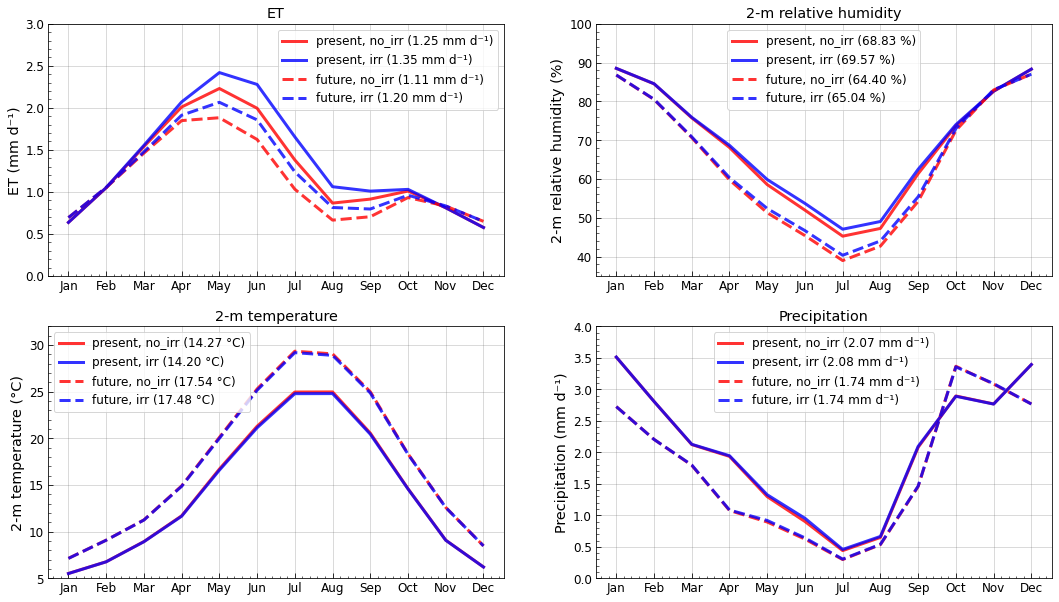

In [ ]:
vars=[ 'evap', 'rh2m', 't2m', 'precip']#,'fluxsens', 'q2m', 's_pblh', 's_lcl',  'LWdnSFC', 'SWdnSFC', 'cldt', 'cldm', 'cldh']

fig,axes= plt.subplots(2,2, figsize=(18,10))
axes=axes.flatten()
vmins=[0, 35, 5, 0, ]
vmaxs=[3, 100, 32, 4]

ds1= ip_lmdz_pres_noirr
ds2= ip_lmdz_pres_irr
ds3= ip_lmdz_fut_noirr
ds4= ip_lmdz_fut_irr

year_min, year_max = 1980, 2080

ds_list = [ds1, ds2, ds3, ds4]
# ds_list=[ds1, ds3]

i=0
for var in vars:
    title='{}'.format(ds1[var].attrs['name'])
    ylabel='{} ({})'.format(ds1[var].attrs['name'], ds1[var].attrs['units'])
    seasonal_cycle_ave(ds_list, var, 
                    title=title,
                    ax=axes[i],
                    ylabel=ylabel,
                    ds_colors=True,
                    ds_linestyle=True,
                    year_min=year_min, year_max=year_max,
                    vmin=vmins[vars.index(var)],
                    vmax=vmaxs[vars.index(var)]
                    )   
    i+=1
